# **ch.08 이미지를 위한 인공 신경망**  
## 08-3 합성곱 신경망의 시각화  
### 풀어야 할 문제:  
> ### feature map visualization을 통해 CNN 이해하기

<br/>

### *가중치 시각화*  
convolution layer는 여러 개의 filter를 사용해 image에서 특징을 학습함  
각 filter는 kernel(weights, intercepts)을 가짐  
일반적으로 intercepts는 시각적으로 의미가 없음  
weights는 input image의 2 dimension 영역에 적용되어 어떠한 특징을 크게 두드러지게 표현하는 역할을 수행

<br/>

앞선 model이 만든 checkpoint file 불러오기

















In [17]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/hongong-machine/best-cnn-model.h5')

model에 추가한 layer는 `layers` attribute(list)에 저장되어 있음


`layers` attribute 확인

In [18]:
model.layers

model의 weights와 intercepts는 `layers` attribute 안의 `weights` attribute(list)에 저장되어 있음


첫 번째 convolution layer의 weights 확인

In [19]:
conv = model.layers[0]
print(conv.weights[0].shape, conv.weights[1].shape)

(3, 3, 1, 32) (32,)


첫 번째 convolution layer의 kernel size를 (3, 3)으로 지정하였고, convolution layer에 전달되는 input data의 channel이 1이었으므로 `conv.weights[0]`의 처음 3개의 dimension은 (3, 3, 1)  
마지막 dimension은 filter 개수가 32개였으므로 32  
&rarr; (3, 3, 1, 32)


`conv.weights[1]`은 intercept의 size인데, filter가 32개였으므로, 각각 intercept 하나씩 해서 (32,)

<br/>

`weights` attribute는 tensorflow의 multi-dimension array인 Tensor class의 object  
이를 다루기 쉽도록 `numpy()` method를 사용해 numpy array로 변환













In [20]:
conv_weights = conv.weights[0].numpy()

weights array의 mean과 standard deviation 계산

In [21]:
print(conv_weights.mean(), conv_weights.std())

-0.036824886 0.26621145


이 weights가 어떠한 distribution(분포)을 가졌는지 알아보기 위해 historam 그려보기  
`hist()` function에는 1 dimension array로 전달해야 함

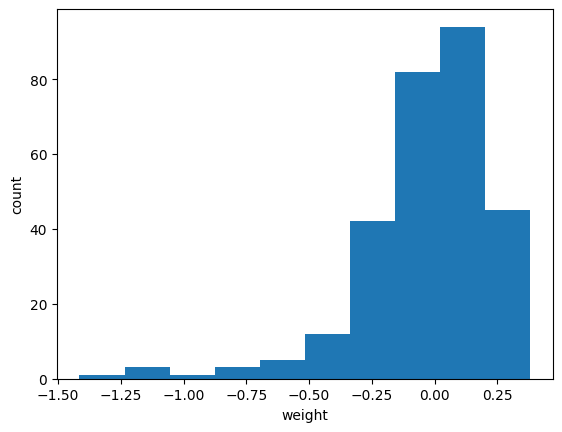

In [22]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

0을 중심으로 종 모양 distribution을 띠고 있음

<br/>

32개의 kernel을 16개씩 두 줄에 그려보기

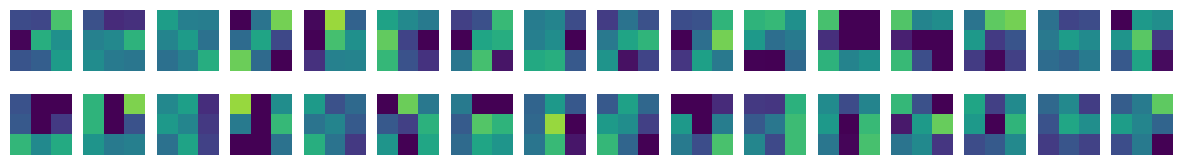

In [23]:
fig, axs = plt.subplots(2, 16, figsize=(15, 2))

for i in range(2):
  for j in range(16):
    axs[i, j].imshow(conv_weights[:, :, 0, i*16+j], vmin=-0.3, vmax=0.5)
    axs[i, j].axis('off')
plt.show()

결과를 보면 weights가 무작위로 나열된 것이 아닌 특정한 pattern이 있음을 알 수 있음  


`imshow()` function은 array에 있는 maximum과 minimum을 사용해 pixel의 강도를 표현  
&rarr; 해당 array의 최댓값을 가장 밝게 표현  
$\therefore$ `imshow()` function의 output으로 서로 다른 두 array를 비교하는 것은 정확하지 않음  
어떠한 공통된 기준을 정해 pixel의 강도를 나타내는 것이 비교하기에 적합함  
&rarr; 이를 위해 `vmin`, `vmax` parameter에 값을 지정하여 colormap으로 표현할 범위를 지정함

<br/>

train되지 않은 빈 CNN 만들어 빈 CNN layer의 weights와 trained CNN의 weights 비교해 보기
+ model 만들기
+ convolution layer 추가하기

In [24]:
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28, 28, 1)))

+ model의 첫 번째 convolution layer의 weights 저장

In [25]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


convolution layer의 structure는 trianed model의 convolution layer와 같으므로 shape도 같음


+ 저장한 weights의 mean과 standard deviation 확인







In [26]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

0.0007536637 0.084961265


+ weights array를 histogram으로 그려보기

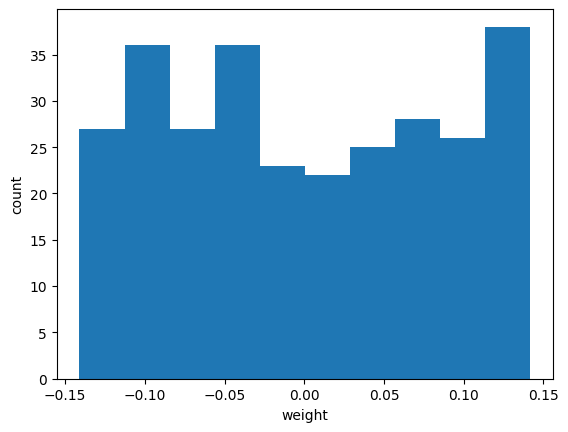

In [27]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

trained model의 convolution layer의 weights의 distribution과 확연히 다름  
비교적 고른 distribution을 보임  
$\because$ tensorflow가 neural network의 초기 weights를 uniform distribution(균등 분포)에서 random하게 value를 선택하기 때문


+ weights 그려보기
  + trained weights와 비교하기 위해 `vmin`, `vmax` parameter value를 동일하게 설정

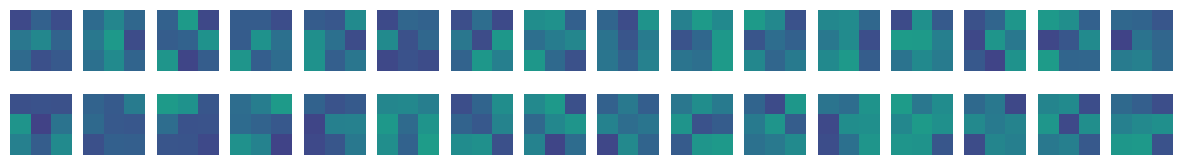

In [28]:
fig, axs = plt.subplots(2, 16, figsize=(15, 2))

for i in range(2):
  for j in range(16):
    axs[i, j].imshow(no_training_weights[:, :, 0, i*16+j], vmin=-0.3, vmax=0.5)
    axs[i, j].axis('off')
plt.show()

histogram에서도 보았듯, 전체적으로 weights가 밋밋하게 초기화되어 있음  
&rarr; CNN이 Fashion MNIST classification의 accuracy를 높이기 위해 유용한 pattern을 학습했음을 알 수 있음

<br/>  
- - -  
<br/>

### *함수형 API*  
지금까지 neural network model을 만들 때 `Sequential` class를 사용했음  
`Sequential` class는 차례대로 layer를 쌓아 model을 만듦  
그러나 deep learning에서는 좀 더 복잡한 model을 많이 사용함  
예를 들어, input이 2개일 수도 있고, output이 2개일 수도 있음  
이런 경우는 `Sequential` class를 사용하기 어려움  
&rarr; functional API를 사용함

<br/>

functional API는 keras의 `Model` class를 사용하여 model을 만듦  


dense layer 2개로 이루어진 full-connected neural network를 functional API로 구현해 보기
+ dense layer object 만들기

In [29]:
dense1 = keras.layers.Dense(100, activation='sigmoid')
dense2 = keras.layers.Dense(10, activation='softmax')

+ layer object를 function 처럼 call하기


python의 모든 object는 callable  
keras의 layer는 object를 function처럼 call했을 때, 적절히 동작할 수 있도록 만들어져있음












In [30]:
inputs = keras.Input(shape=(784,))

In [31]:
hidden = dense1(inputs)

위 code를 실행하면 input인 `inputs`를 dense layer에 통과시킨 후 output으로 `hidden`을 만들어 줌


+ 두 번째 layer object call하기











In [32]:
outputs = dense2(hidden)

+ `inputs`와 `outputs`를 `Model` class로 연결

In [33]:
model = keras.Model(inputs, outputs)

input에서 output까지 layer를 call한 결과를 계속 이어주고, `Model` class에 input과 최종 output을 지정


`Sequential` class는 `InputLayer` class를 자동으로 추가하고 call해 주지만, `Model` class에서는 수동으로 만들어 call해야 함  
위 code에서 `inputs`가 `InputLayer`의 output이 되어야 함


keras는 `InputLayer` class object를 쉽게 다룰 수 있도록 `Input()` function을 별도로 제공  
input의 size를 지정하는 `shape` parameter와 함께 `Input()` function을 call하면 `InputLayer` class object를 만들어 output을 return해 줌

In [34]:
inputs = keras.Input(shape=(784,))

이렇게 model을 만들면 중간에 다양한 형태로 layer를 연결할 수 있음

<br/>

feature map의 visualization을 위해서는 이러한 functional API를 활용해야 함  


예를 들어, `Sequential` class로 CNN model을 구현하면 첫 번째 convolution layer의 output인 feature map을 구할 수 없음  
`Sequential` class로 구현한 model의 output은 `predict()` method로 모든 연산을 수행한 후의 최종 output만 얻을 수 있음  
하지만 이 상황에서 필요한 것은 첫 번째 convolution layer의 feature map  
functional API를 사용하면 `Conv2D` class object의 `output` attribute에서 feature map을 얻을 수 있고, model object의 input도 `model`의 `input` attribute로 간단히 얻을 수 있음

<br/>

model의 input 확인

In [35]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


model object의 `predict()` method를 call하면 최종 output layer의 probability를 return

<br/>  
- - -  
<br/>

### *특성 맵 시각화*  
data set을 준비하고 첫 번째 sample 그려보기

4422102/4422102 [==============================] - 0s 0us/step


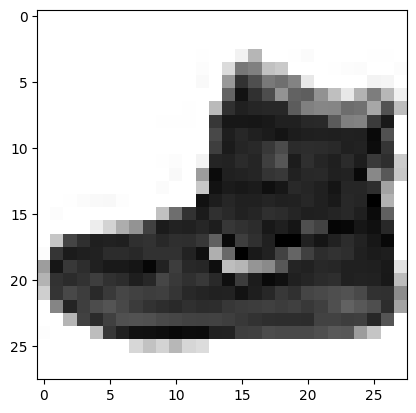

In [36]:
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

plt.imshow(train_input[0], cmap='gray_r')
plt.show()

functional API로 CNN model 만들기

In [38]:
inputs = keras.Input(shape=(28, 28, 1))

conv1 = keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
pool1 = keras.layers.MaxPooling2D(2)
conv2 = keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
pool2 = keras.layers.MaxPooling2D(2)
flat = keras.layers.Flatten()
dense = keras.layers.Dense(100, activation='relu')
dropout = keras.layers.Dropout(0.3)
output = keras.layers.Dense(10, activation='softmax')

hidden_conv1 = conv1(inputs)
hidden_pool1 = pool1(hidden_conv1)
hidden_conv2 = conv2(hidden_pool1)
hidden_pool2 = pool2(hidden_conv2)
out_flat = flat(hidden_pool2)
hidden_dense = dense(out_flat)
out_dropout = dropout(hidden_dense)
outputs = output(out_dropout)

model = keras.Model(inputs, outputs)

`model.input`과  `model.layers[1].output` (첫 번째 convolution layer의 feature map)을 연결하는 새로운 model 만들기

In [45]:
conv_acti = keras.Model(model.input, model.layers[1].output)

train set의 첫 번째 sample을 `conv_acti` model에 입력하여 첫 번째 convoution layer가 만드는 feature map 출력해 보기  
+ `predict()` method는 항상 input의 첫 번째 dimension이 batch dimension일 것이라 기대하기 때문에 하나의 sample을 입력하더라도 input의 첫 번째 dimension을 유지해야 함  
&rarr; slicing을 사용하여 첫 번째 sample 선택하기
+ sample의 pixel value를 255로 나누어 scale normalization

In [46]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0

feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 0s 156ms/step


+ `feature_maps` shape 확인

In [47]:
print(feature_maps.shape)

(1, 28, 28, 32)


same padding과 32개의 filter를 사용한 convolution layer의 output이고, 첫 번째 dimension은 batch dimension이므로 (1, 28, 28, 32)

<br/>

+ visualize `feature_maps`
  + `imshow()` function 사용
  + 32개의 feature map이 있으므로, 4개의 row로 나누어 그리기

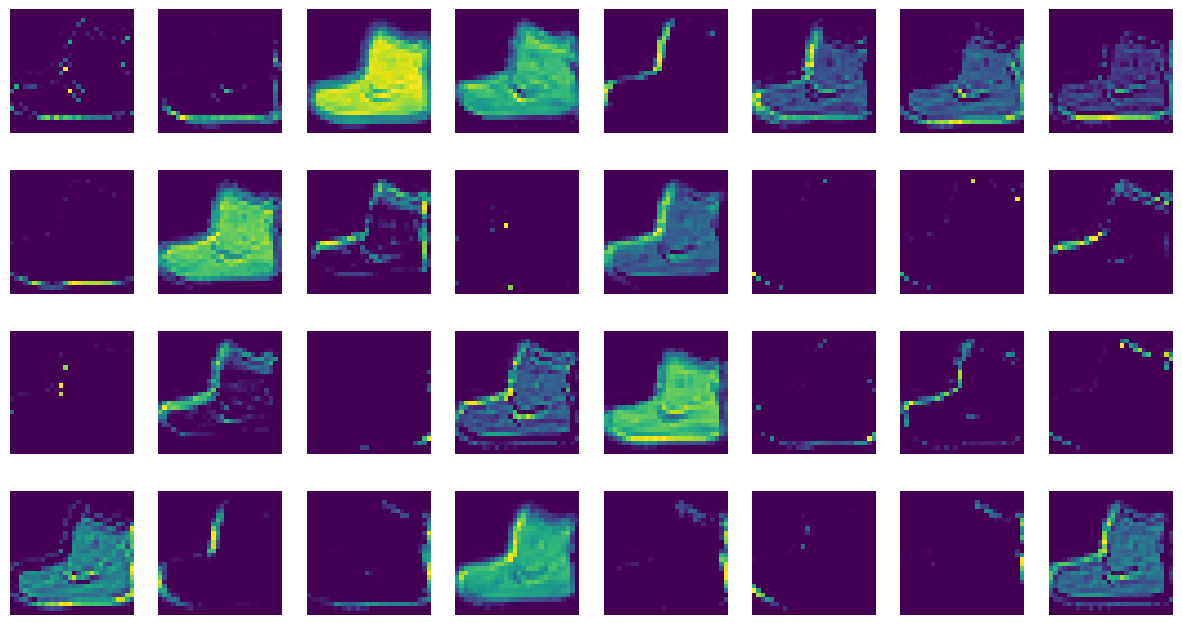

In [48]:
fig, axs = plt.subplots(4, 8, figsize=(15, 8))

for i in range(4):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i*8+j])
    axs[i, j].axis('off')
plt.show()

이 feature map은 32개의 filter로 인해 input image에서 강하게 활성화된 부분을 보여 줌

<br/>

두 번째 convolution layer가 만든 feature map도 같은 방식으로 확인할 수 있음
+ model object의 input과 두 번째 convolution layer의 output을 연결한 model 만들기

In [49]:
conv2_acti = keras.Model(model.input, model.layers[3].output)

+ train set의 첫 번째 sample을 `conv2_acti` model의 `predict()` method에 전달

In [50]:
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0

feature_maps = conv2_acti.predict(inputs)

1/1 [==============================] - 0s 232ms/step


+ `feature_maps`의 shape 확인

In [51]:
print(feature_maps.shape)

(1, 14, 14, 64)


첫 번째 dimension은 batch dimension이므로 1이고, 첫 번째 pooling layer에서 2 dimension size가 절반으로 줄었고, 두 번째 convolution layer의 filter 수는 64이므로 세 번째 dimension은 64  
&rarr; (1, 14, 14, 64)

+ visualize `feature_maps`
  + 64개의 feature map이 있으므로, 8개 row에 나누어 그리기

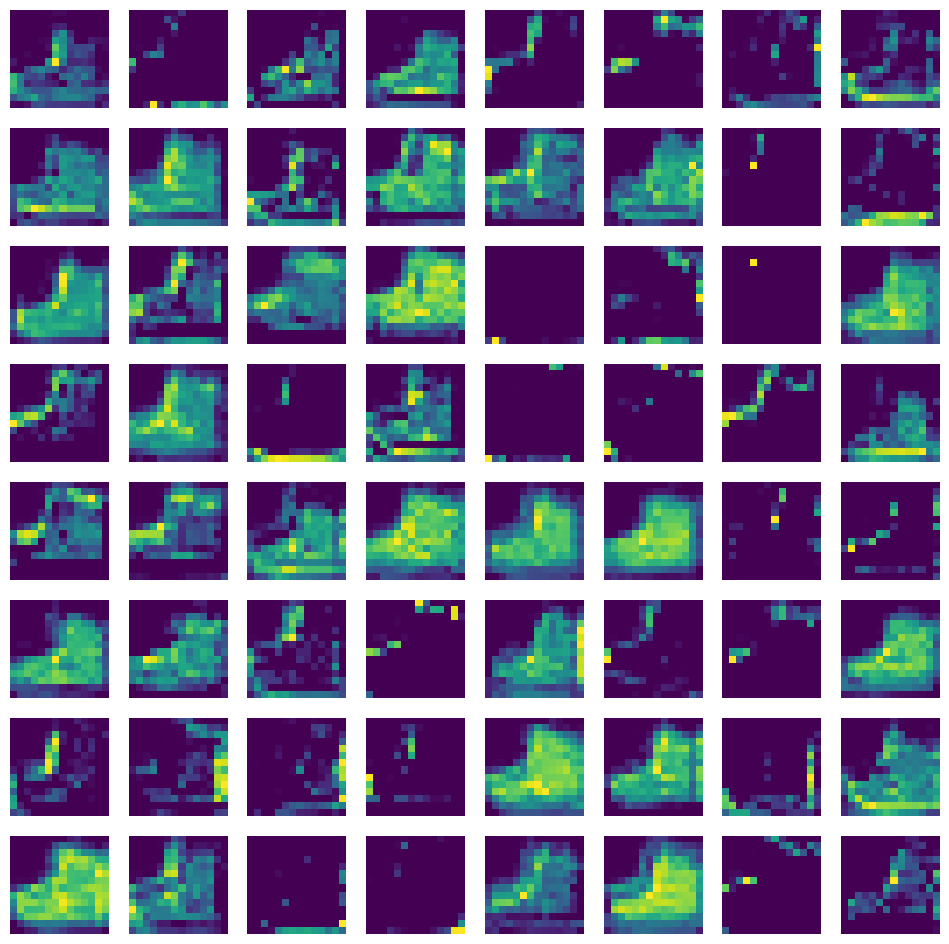

In [53]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))

for i in range(8):
  for j in range(8):
    axs[i, j].imshow(feature_maps[0, :, :, i*8+j])
    axs[i, j].axis('off')
plt.show()

이 feature map에는 이해하기 어려운 featur map도 있음  


두 번째 convolution layer의 filter 크기는 (3, 3, 32)  
두 번째 convolution layer의 첫 번째 filter가 앞서 출력한 32개의 feature map과 곱해져 두 번째 convolution layer의 첫 번째 feature map이 됨  
이렇게 계산된 output은 (14, 14, 32) feature map에서 어떤 부분을 감지하는지는 직관적으로 이해하기 어려움  
이러한 현상은 convolution layer를 많이 쌓을수록 심해짐  
&rarr; convolution neural network의 앞부분에 있는 convolution layers는 image의 시각적인 information을 감지하고 뒤쪽에 있는 convolution layers는 앞쪽에서 감지한 시각적인 information을 바탕으로 추상적인 information을 학습한다고 생각할 수 있음